In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import itertools
from torchvision import transforms
from torchvision.utils import save_image
import torch.nn.functional as F
import torchvision.utils as vutils

In [ ]:
batch_size=100
# transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean=(0.5, ), std=(0.5, ))])
transform = transforms.Compose([
                                transforms.ToTensor()
])
train_data = torchvision.datasets.MNIST('/content/', train = True,
                           transform=transform, download = True)
test_data = torchvision.datasets.MNIST('/content/', train = False,
                           transform=transform, download = True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class Generator(nn.Module):
    def __init__(self, nc=1, nz=100, ngf=32):
      super(Generator, self).__init__()
      self.network = nn.Sequential(
          nn.ConvTranspose2d(100, ngf*4, 4, 1, 0, bias=False),  #100x1x1->128x4x4 
          nn.BatchNorm2d(ngf*4),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 1, bias=False), #128x4x4->64x7x7
          nn.BatchNorm2d(ngf*2),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False), #64x7x7->32x14x14
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False), #32x14x14->1x28x28
          nn.Tanh()
      )
  
    def forward(self, input):
      output = self.network(input)
      return output

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=32):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
                
                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),  #1x28x28 => 32x14x14
                nn.LeakyReLU(0.1, inplace=True),
                
                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  #32x14x14 => 64x7x7
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.1, inplace=True),
                
                nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),  #64x7x7 => 128x4x4
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.1, inplace=True),
                
                nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),  #128x4x4 => 1x1x1
                nn.Sigmoid()
            )
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1,64,5,2,2)
        self.lr1 = nn.LeakyReLU()
        
        self.conv2 = nn.Conv2d(64,128,5,2,2)
        self.lr2 = nn.LeakyReLU()

        self.linear = nn.Linear(128*7*7,1)
        self.sig = nn.Sigmoid()

    def forward(self,input):
      out=self.conv1(input)
      out=self.lr1(out)
      out=self.conv2(out)
      out=self.lr2(out)
      out=out.view((-1,128*7*7))
      out=self.linear(out)
      out=self.sig(out)
      return out.view(-1, 1).squeeze(1)

In [ ]:
device='cuda'
epochs=200
nz=100
fixed_noise = torch.randn((16,nz,1,1),dtype=torch.float32,device=device)
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
real_label = torch.full((batch_size,),1,dtype=torch.float32,device=device)
fake_label = torch.full((batch_size,),0,dtype=torch.float32,device=device)
optimizer_g = optim.Adam(generator.parameters(), lr=0.0001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
generator

Generator(
  (network): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [ ]:
def generate_samples(epoch,out,path,fixed_noise):
  l = int(np.sqrt(fixed_noise.shape[0]))
  fig, ax = plt.subplots(l, l, figsize=(6,6))
  for i, j in itertools.product(range(l), range(l)):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
  for k in range(int(fixed_noise.shape[0])):
      i = k//4
      j = k%4
      ax[i,j].cla()
      # print(out[k].type)
      ax[i,j].imshow(out[k].data.cpu().numpy().reshape(28,28), cmap='Greys')
  label = 'Epoch_{}'.format(epoch+1)
  # fig.text(0.5, 0.04, label, ha='center')
  # fig.suptitle(title)
  fig.savefig(path+label+'.png')


Epoch [1/200], Discrimintor loss: 0.004611, Generator loss: 0.159975
Epoch [2/200], Discrimintor loss: 0.001402, Generator loss: 0.140989
Epoch [3/200], Discrimintor loss: 0.002145, Generator loss: 0.080212
Epoch [4/200], Discrimintor loss: 0.008607, Generator loss: 0.171252
Epoch [5/200], Discrimintor loss: 0.008135, Generator loss: 0.100203
Epoch [6/200], Discrimintor loss: 0.000875, Generator loss: 0.159082
Epoch [7/200], Discrimintor loss: 0.000986, Generator loss: 0.112624
Epoch [8/200], Discrimintor loss: 0.001734, Generator loss: 0.187908
Epoch [9/200], Discrimintor loss: 0.003694, Generator loss: 0.044784
Epoch [10/200], Discrimintor loss: 0.002533, Generator loss: 0.176045
Epoch [11/200], Discrimintor loss: 0.003733, Generator loss: 0.082814
Epoch [12/200], Discrimintor loss: 0.005845, Generator loss: 0.080714
Epoch [13/200], Discrimintor loss: 0.002475, Generator loss: 0.138507
Epoch [14/200], Discrimintor loss: 0.000906, Generator loss: 0.139222
Epoch [15/200], Discrimintor 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch [101/200], Discrimintor loss: 0.005119, Generator loss: 0.195983
Epoch [102/200], Discrimintor loss: 0.000352, Generator loss: 0.137551
Epoch [103/200], Discrimintor loss: 0.000190, Generator loss: 0.125222
Epoch [104/200], Discrimintor loss: 0.000974, Generator loss: 0.215022
Epoch [105/200], Discrimintor loss: 0.002454, Generator loss: 0.217587
Epoch [106/200], Discrimintor loss: 0.001076, Generator loss: 0.043921
Epoch [107/200], Discrimintor loss: 0.000609, Generator loss: 0.149272
Epoch [108/200], Discrimintor loss: 0.005344, Generator loss: 0.246547
Epoch [109/200], Discrimintor loss: 0.000007, Generator loss: 0.194998
Epoch [110/200], Discrimintor loss: 0.000050, Generator loss: 0.202161
Epoch [111/200], Discrimintor loss: 0.000091, Generator loss: 0.129010
Epoch [112/200], Discrimintor loss: 0.000075, Generator loss: 0.165703
Epoch [113/200], Discrimintor loss: 0.000099, Generator loss: 0.156945
Epoch [114/200], Discrimintor loss: 0.000035, Generator loss: 0.153510
Epoch 

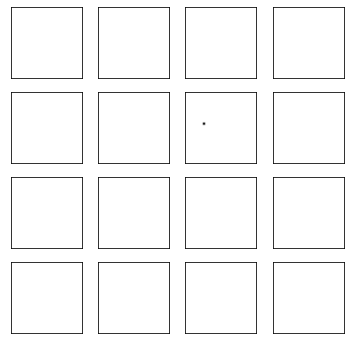

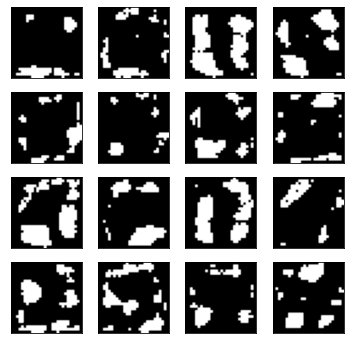

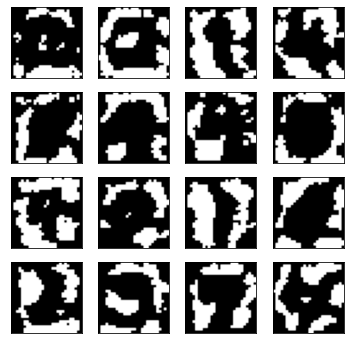

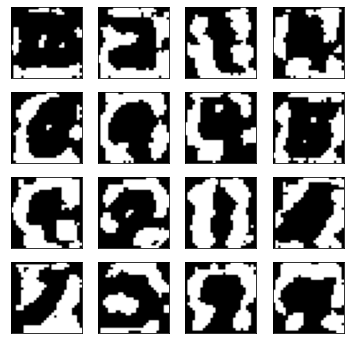

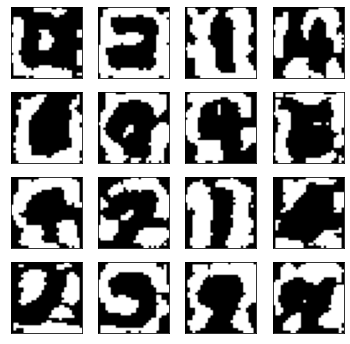

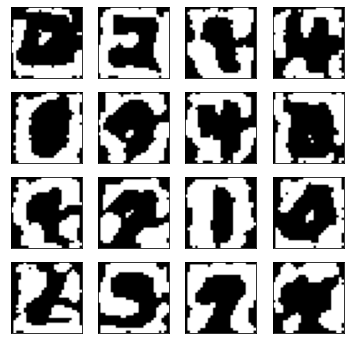

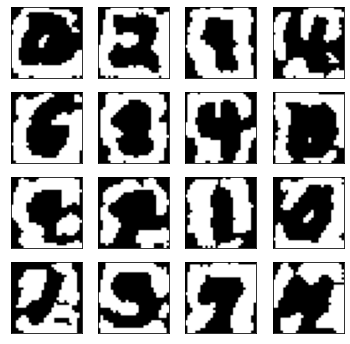

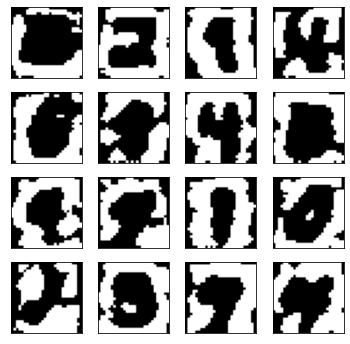

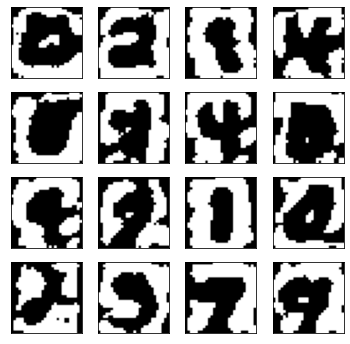

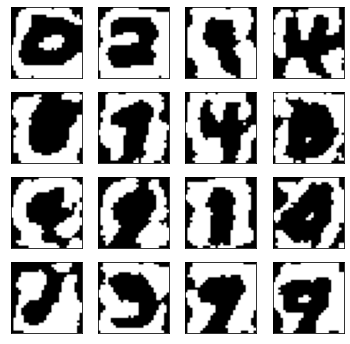

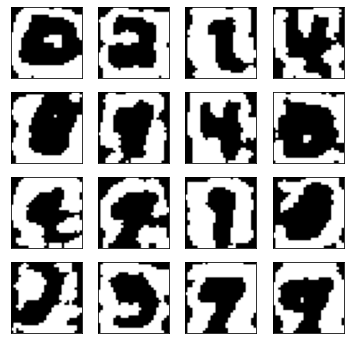

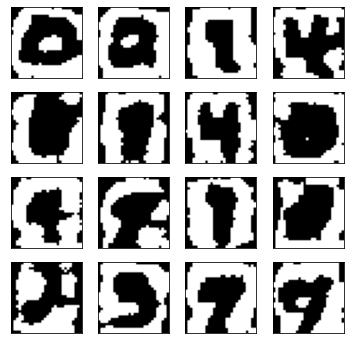

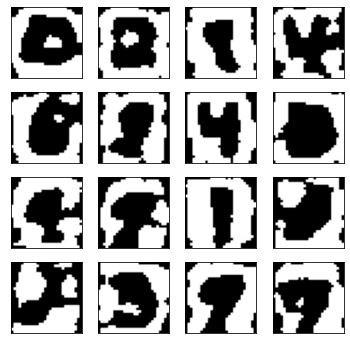

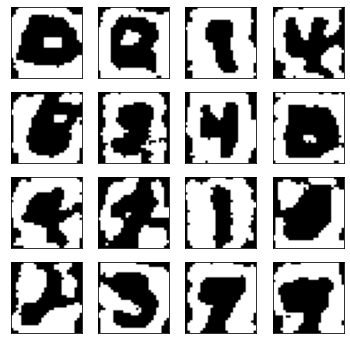

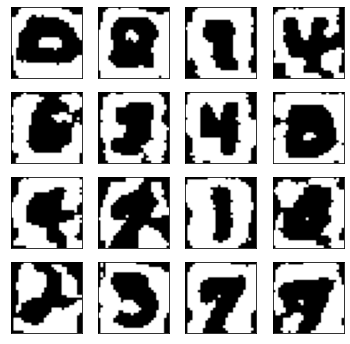

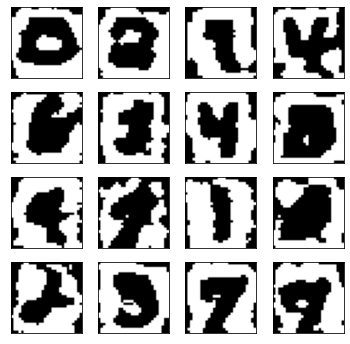

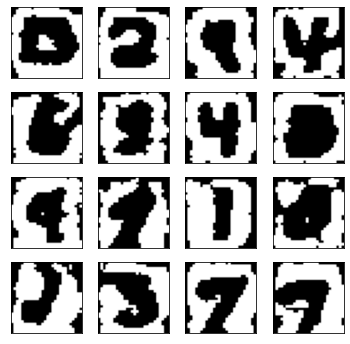

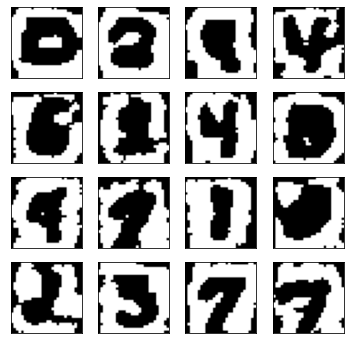

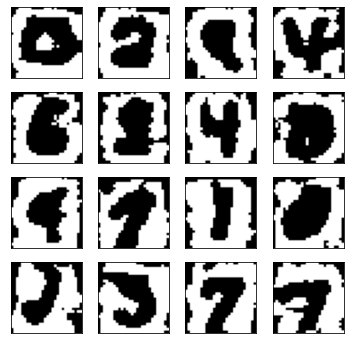

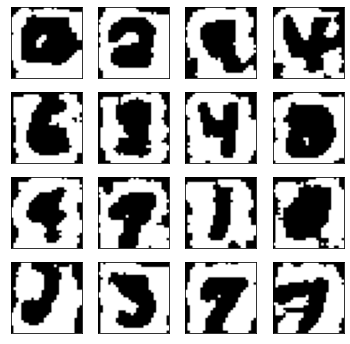

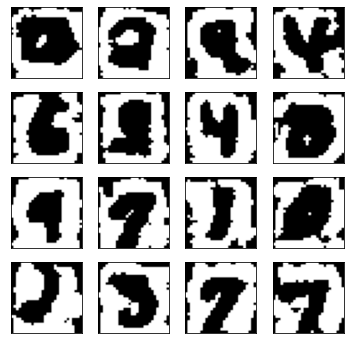

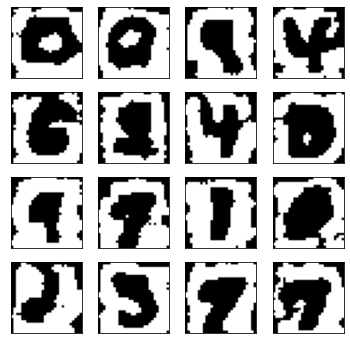

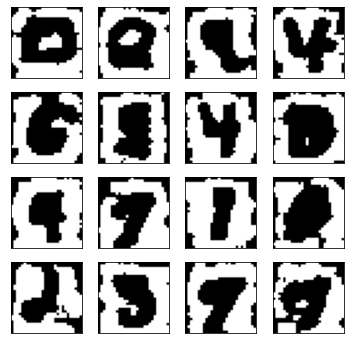

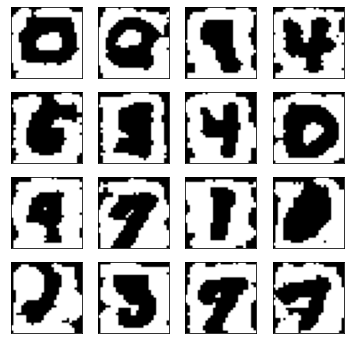

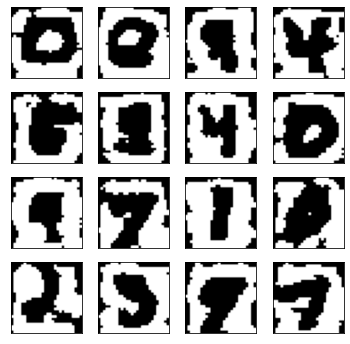

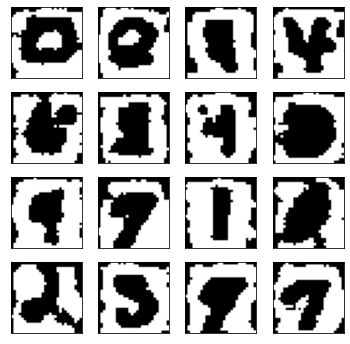

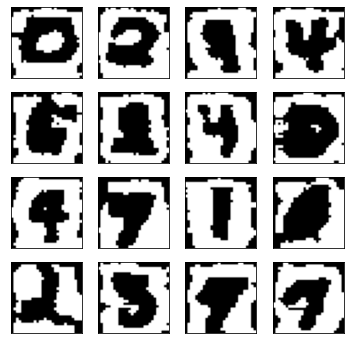

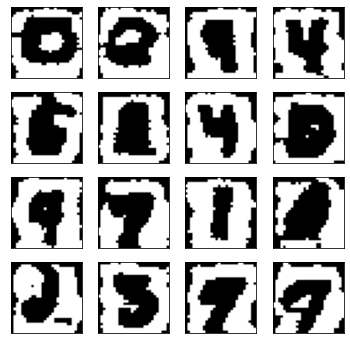

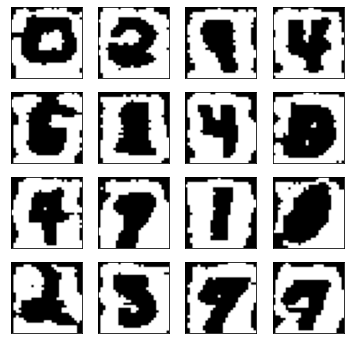

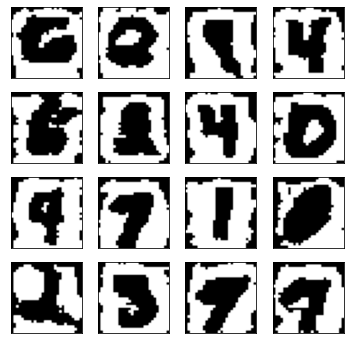

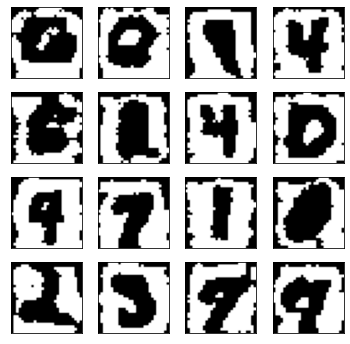

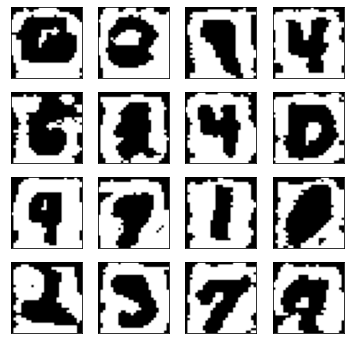

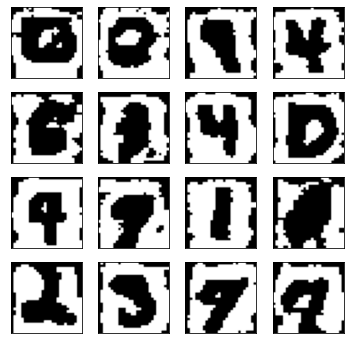

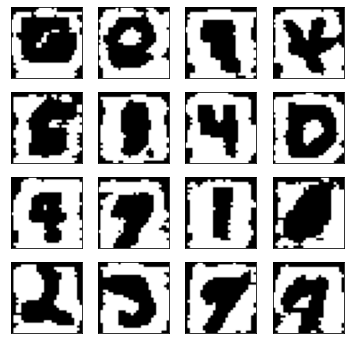

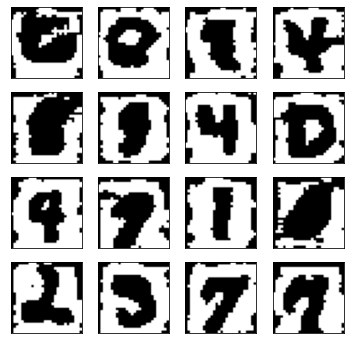

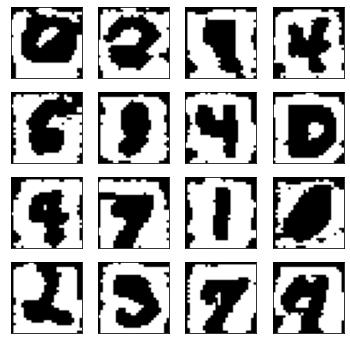

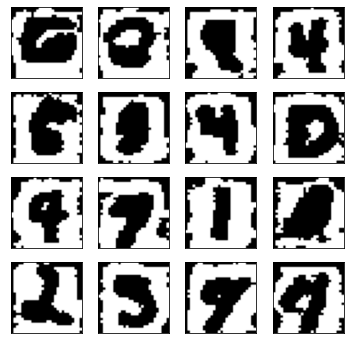

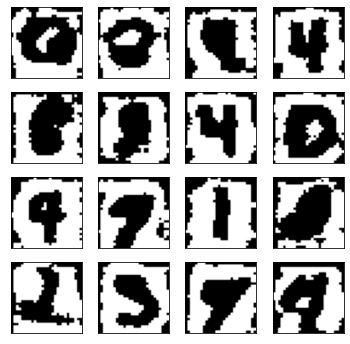

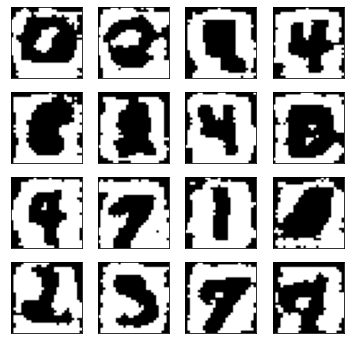

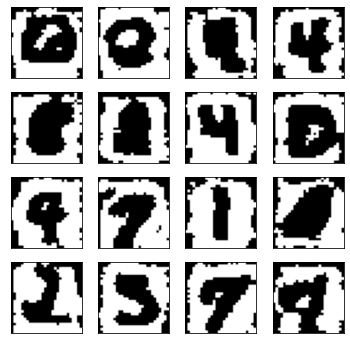

In [ ]:
for epoch in range(epochs):
  gen_loss=[]
  dis_loss=[]
  for i, (data,_) in enumerate(train_loader):
    ## maximizing log(d(x)) + log(1-D(G(z)))
    data = data.to(device)
    discriminator.zero_grad()
    #compute real loss
    d_x = discriminator(data)
    loss_dis_real = criterion(d_x, real_label)
    #compute fake loss
    latent1 = torch.randn((batch_size,nz,1,1),dtype=torch.float32,device=device)
    with torch.no_grad():
      sample_gz = generator(latent1)
    sample_dgz = discriminator(sample_gz)
    loss_dis_fake = criterion(sample_dgz, fake_label)
    loss_dis = (loss_dis_real+loss_dis_fake)/2
    loss_dis.backward()
    optimizer_d.step()


    ## maximizing log(D(G(z)))
    latent = torch.randn((batch_size,nz,1,1), device=device)
    generator.zero_grad()
    g_z = generator(latent)
    d_g_z = discriminator(g_z)
    loss_gen = criterion(d_g_z, real_label)
    loss_gen.backward()
    optimizer_g.step()

  if epoch%5==0:
    with torch.no_grad():
      out = generator(fixed_noise)
      out = out.type(torch.int32)
    generate_samples(epoch,out,'/content/drive/MyDrive/VAE/DCGAN/',fixed_noise)
  
  gen_loss.append(loss_gen.item()/batch_size)
  dis_loss.append(loss_dis.item()/batch_size)
  print('Epoch [{}/{}], Discrimintor loss: {:.6f}, Generator loss: {:.6f}'.format(epoch+1,epochs,loss_dis.item()/batch_size,loss_gen.item()/batch_size))


    



